In [1]:
import transformers
from transformers import BertTokenizer, BertModel, BertForMaskedLM, AdamW, BertForSequenceClassification
# from transformers import get_linear_schedule_with_warmup
from pytorch_transformers import WarmupLinearSchedule
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import Dense
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasClassifier
# from pytorch_pretrained_bert import BertAdam
import torch
from torch import tensor
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm, trange, tqdm_notebook
import time
import datetime
import random
from keras.utils import to_categorical
from keras.models import Model
import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
import time
from pprint import pprint
from tabulate import tabulate
# from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
import warnings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
df = pd.read_csv('file.csv')
df = df.rename(columns={'article':'body'})
df.generally_bad_score = df.generally_bad_score.apply(lambda x: 1 if x > 2 else 0)
# Convert from float to int
# df.generally_bad_score = df.generally_bad_score.astype('float')
# pd.options.display.float_format = '{:,.0f}'.format
df = df.drop(['article_id', 'title'], axis=1)
df.head()

,body,generally_bad_score
0,Stitch Fix said it ended the quarter with abou...,1
1,Only two of the murder cases have made it to t...,0
2,*FDA Requests Meeting With Walgreens Corporate...,1
3,Mr. Powell said Fed officials are near agreeme...,1
4,In the few days since former Deputy Commission...,1


# Preprocessing

In [3]:
df.body = df.body.str.lower()
df.body = df.body.str.translate(str.maketrans('', '', string.digits))
df.body = df.body.str.translate(str.maketrans('', '', string.punctuation))
df.body = df.body.str.replace('bedandbreakfast', 'bed and breakfast')
df.body = df.body.str.replace('yearold', 'year old')
df.body = df.body.str.replace('obama—who', 'obama who')
df.body = df.body.str.replace('friendofthecourt', 'friend of the court')
df.body = df.body.str.replace('chicago—to', 'chicago to')
df.body = df.body.str.replace('way…to', 'way to')
df.body = df.body.str.replace('-', '')
df.body = df.body.str.replace('said—that', 'said that')
df.body = df.body.str.replace('firstdegree', 'first degree')
df.body = df.body.str.replace('andmark', 'and mark')
df.body = df.body.str.replace('seconddegree', 'second degree')
df.body = df.body.str.replace('mutiple', 'multiple')
df.body = df.body.str.replace('sevenpage', 'seven page')
df.body = df.body.str.replace('centerpiece', 'center piece')
df.body = [re.sub(' +', ' ', x) for x in df.body]
stop = stopwords.words('english')
df.body = df.body.str.split()
df.body = df.body.apply(lambda x: [item for item in x if item not in stop])
df.body = [' '.join(i) for i in df.body]
temp = df.body
df.body = ["[CLS] " + sentence + " [SEP]" for sentence in df.body]

# MODEL BUILDING

In [4]:
%%time
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_texts = [tokenizer.tokenize(sent) for sent in df.body]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'stitch', 'fix', 'said', 'ended', 'quarter', 'million', 'active', 'clients', 'period', 'year', 'earlier', 'revenue', 'per', 'active', 'client', 'also', 'grew', 'year', 'ago', 'active', 'clients', 'received', 'shipment', 'past', 'year', 'stitch', 'fix', 'shares', 'gained', 'year', 'also', 'posted', 'similar', 'gains', 'company', '##s', 'second', '##qua', '##rter', 'report', 'march', 'earnings', 'beating', 'internal', 'analyst', 'forecast', '##s', 'however', 'higher', 'selling', 'administrative', 'costs', 'weighed', 'company', '##s', 'profit', 'latest', 'period', 'result', 'still', 'better', 'analysts', 'expected', 'profit', 'fell', 'million', 'cents', 'share', 'company', 'warned', 'march', 'marketing', 'spending', 'costs', 'tied', 'expansion', 'uk', 'would', 'hurt', 'third', '##qua', '##rter', 'profit', 'katrina', 'lake', 'stitch', 'fix', '##s', 'chief', 'executive', 'said', 'conference', 'call', 'analysts', 'company', 'completed', 'launch', 'last'

In [5]:
input_ids=[]
for i in tqdm_notebook(range(len(tokenized_texts))):
    input_ids.append(tokenizer.convert_tokens_to_ids(tokenized_texts[i]))

In [6]:
MAX_LEN = 256
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [7]:
#Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [8]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, df.generally_bad_score, random_state=56, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=56, test_size=0.2)

In [9]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels.values)
validation_labels = torch.tensor(validation_labels.values)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [10]:
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [11]:
## Define model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device ='cpu'
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [12]:
lr = 2e-5
max_grad_norm = 1.0
num_total_steps = 1000
num_warmup_steps = 100
warmup_proportion = float(num_warmup_steps) / float(num_total_steps)  # 0.1

### In PyTorch-Transformers, optimizer and schedules are splitted and instantiated like this:
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

In [13]:
total_step = len(train_dataloader)

# Store our loss and accuracy for plotting
train_loss_set = []

epochs = 2

# trange is a tqdm wrapper around the normal python range
for epoch in tqdm_notebook(range(epochs)):

    # Training
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Train the data for one epoch
    for i, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        if (i) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
        

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Epoch [1/2], Step [1/52], Loss: 0.5966
Epoch [1/2], Step [51/52], Loss: 0.7106


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Epoch [2/2], Step [1/52], Loss: 0.4790
Epoch [2/2], Step [51/52], Loss: 0.3789



In [14]:
torch.save(model.state_dict(), os.getcwd()+'/model_without_language_model.ckpt')

In [15]:
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        # print (outputs)
        prediction = torch.argmax(outputs[0],dim=1)
        total += b_labels.size(0)
        correct+=(prediction==b_labels).sum().item()

In [16]:
print('Test Accuracy of the model on val data is: {} %'.format(roc_auc_score(b_labels, prediction)))
print('{}'.format(classification_report(b_labels, prediction)))

Test Accuracy of the model on val data is: 0.6590909090909092 %
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       0.82      0.82      0.82        11

    accuracy                           0.73        15
   macro avg       0.66      0.66      0.66        15
weighted avg       0.73      0.73      0.73        15



# Transfer Learning

In [17]:
saver = keras.callbacks.ModelCheckpoint(os.getcwd()+"/model_without_language_model.ckpt", save_weights_only=True)

**This might be useful not sure yet though**

In [18]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(temp.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 37553 unique tokens.


**Ends here**

In [19]:
X = tokenizer.texts_to_sequences(temp.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
Y = pd.get_dummies(df.generally_bad_score).values

In [20]:
train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size=.20)

**This is the model that gave the best result so far, but have only tested LSTM RNN and didn't fully tune this model**

In [21]:
# model = Sequential()
# model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(6, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**Ends here**

In [22]:
model = Sequential()
model.add(Dense(12, input_dim=250, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_features, train_labels, epochs=5, batch_size=64,validation_split=0.2, callbacks=[saver])
# Final evaluation of the model
model_pred_train = model.predict(train_features)
model_pred_test = model.predict(test_features)


Train on 660 samples, validate on 166 samples
Epoch 1/5
660/660 [==============================] - 0s 652us/step - loss: 2633.3125 - accuracy: 0.5682 - val_loss: 1847.9222 - val_accuracy: 0.7349
Epoch 2/5
660/660 [==============================] - 0s 43us/step - loss: 1731.9399 - accuracy: 0.7515 - val_loss: 1534.0898 - val_accuracy: 0.7229
Epoch 3/5
660/660 [==============================] - 0s 45us/step - loss: 1233.9616 - accuracy: 0.7273 - val_loss: 1272.5701 - val_accuracy: 0.6506
Epoch 4/5
660/660 [==============================] - 0s 45us/step - loss: 933.5868 - accuracy: 0.6939 - val_loss: 988.2179 - val_accuracy: 0.6566
Epoch 5/5
660/660 [==============================] - 0s 40us/step - loss: 678.5280 - accuracy: 0.7030 - val_loss: 738.3949 - val_accuracy: 0.6867


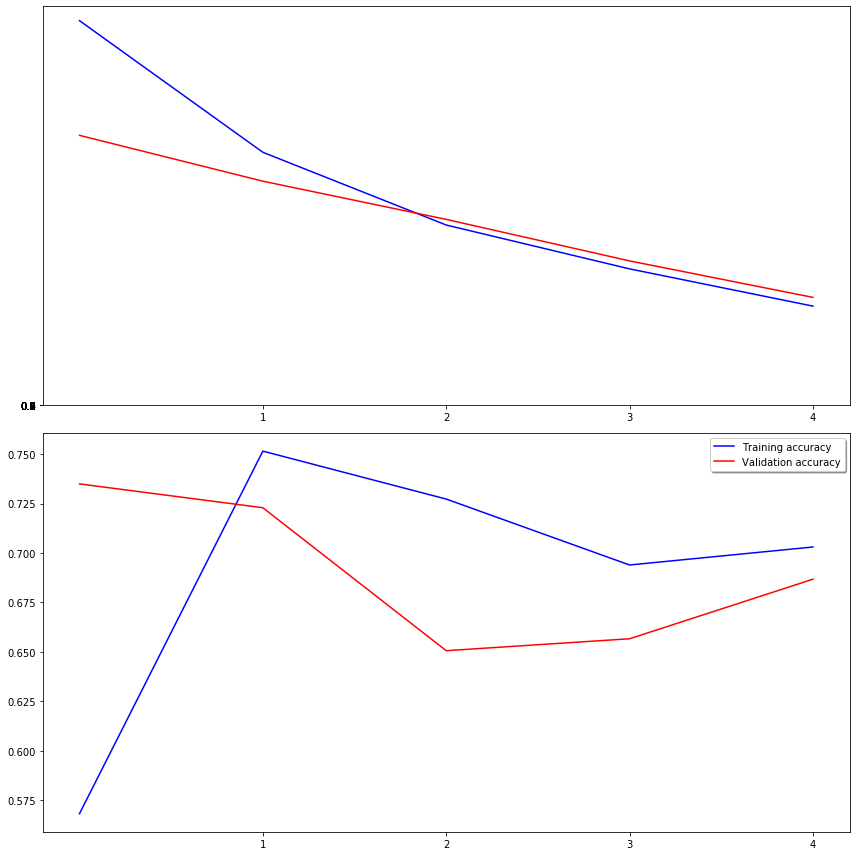

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 5, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 5, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [24]:
print('LSTM Recurrent Neural Network baseline: ' + str(roc_auc_score(train_labels, model_pred_train)))
print('LSTM Recurrent Neural Network: ' + str(roc_auc_score(test_labels, model_pred_test)))
# Not sure if this last part for classification report is correct or not (Found by the Chinese)
for i in range(len(model_pred_train)):
    max_value=max(model_pred_train[i])
    for j in range(len(model_pred_train[i])):
        if max_value==model_pred_train[i][j]:
            model_pred_train[i][j]=1
        else:
            model_pred_train[i][j]=0
                
for i in range(len(model_pred_test)):
    max_value=max(model_pred_test[i])
    for j in range(len(model_pred_test[i])):
        if max_value==model_pred_test[i][j]:
            model_pred_test[i][j]=1
        else:
            model_pred_test[i][j]=0
print('LSTM Recurrent Neural Network baseline:\n\n ' + str(classification_report(train_labels, model_pred_train)))
print('LSTM Recurrent Neural Network:\n\n ' + str(classification_report(test_labels, model_pred_test)))

LSTM Recurrent Neural Network baseline: 0.5320801053217883
LSTM Recurrent Neural Network: 0.4455409356725146
LSTM Recurrent Neural Network baseline:

               precision    recall  f1-score   support

           0       0.22      0.25      0.23       145
           1       0.84      0.81      0.82       681

   micro avg       0.71      0.71      0.71       826
   macro avg       0.53      0.53      0.53       826
weighted avg       0.73      0.71      0.72       826
 samples avg       0.71      0.71      0.71       826

LSTM Recurrent Neural Network:

               precision    recall  f1-score   support

           0       0.11      0.14      0.12        36
           1       0.81      0.76      0.78       171

   micro avg       0.65      0.65      0.65       207
   macro avg       0.46      0.45      0.45       207
weighted avg       0.69      0.65      0.67       207
 samples avg       0.65      0.65      0.65       207



# Hyper Parameter Tuning

In [25]:
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=250, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# create model
model = KerasClassifier(build_fn=create_model, verbose=0, epochs=100, batch_size=10)
# define the grid search parameters
param_grid = {
#     'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#     'batch_size': [10, 20, 40, 60, 80, 100],
#     'epochs': [10, 50, 100],
#     'learn_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
#     'momentum': [0.0, 0.2, 0.4, 0.6, 0.8, 0.9],
#     'init_mode': ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
#     'activation': ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
#     'weight_constraint': [1, 2, 3, 4, 5],
#     'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
#     'neurons': [1, 5, 10, 15, 20, 25, 30]
    
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                      cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

# Fit the grid search to the data
grid_result = grid_search.fit(train_features, train_labels);

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.5s finished


Best: 0.750605 using {}
0.750605 (0.011494) with: {}


# Possibly add Precision_Recall_Curve and ROC_Curve and do feature selection with Tree model?